In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import delle librerie**

In [2]:
from sklearn.datasets import load_iris

from sklearn import datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

# Recupero path di Colab 

In [12]:
path_principale = '/content/drive/Shareddrives/Progetti FVAB 22 23 - VSR & BABELE/Gruppi/Gruppo 22/Progetto BABELE/'

# **Salvataggio lista di librerie e versioni installate**

In [ ]:
!pip freeze > "/content/drive/Shareddrives/Progetti FVAB 22 23 - VSR & BABELE/Gruppi/Gruppo 22/Progetto BABELE/requirements_pnn.txt"

# Caricamento dataset CH-SIMS_CMU-MOSEI
*   Training set
*   Validation set
*   Test set

### Caricamento Train 

In [3]:
def carica_train_chsim_cmumosei(print_tables=False):

    # Definisci i percorsi e i nomi dei file
    data_folder = 'CSV_DATASET_CH-SIMS_CMU-MOSEI/Train/'
    csv_filename = 'Train_CH-SIMS_CMU-MOSEI_cineseVsInglese.csv'
    full_path = path_principale + data_folder + csv_filename

    # Leggi il file CSV e assegna i dati al dataframe df_train
    df_train = pd.read_csv(full_path)

    # Rimuovi le colonne "target" e "video-frame" dal dataframe e assegna i dati rimanenti alla matrice delle features X
    X_train = df_train.drop(columns=['target', 'video-frame'])

    if print_tables:
        # Stampa la matrice delle features X
        print('-' * 50 + ' X_TRAIN ' + '-' * 50)
        display(X_train)

    # Seleziona la colonna "target" e assegna i dati all'array delle etichette Y
    Y_train = df_train[['target']]

    if print_tables:
        # Stampa l'array delle etichette Y
        print('-' * 50 + ' Y_TRAIN ' + '-' * 50)
        display(Y_train)

    return X_train, Y_train



### Caricamento Test

In [4]:
def carica_test_chsim_cmumosei(print_tables=False):

    # Definisci il percorso e il nome del file CSV di test
    data_folder = 'CSV_DATASET_CH-SIMS_CMU-MOSEI/Test/'
    csv_filename = 'Test_CH-SIMS_CMU-MOSEI_cineseVsInglese.csv'
    full_path = path_principale + data_folder + csv_filename

    # Leggi il file CSV e assegna i dati al dataframe df_test
    df_test = pd.read_csv(full_path)

    # Rimuovi le colonne "target" e "video-frame" dal dataframe e assegna i dati rimanenti alla matrice delle features X
    X_test = df_test.drop(columns=['target', 'video-frame'])

    if print_tables:
        # Stampa la matrice delle features X
        print('-' * 50 + ' X_TEST ' + '-' * 50)
        display(X_test)

    # Seleziona la colonna "target" e assegna i dati all'array delle etichette Y
    Y_test = df_test[['target']]

    if print_tables:
        # Stampa l'array delle etichette Y
        print('-' * 50 + ' Y_TEST ' + '-' * 50)
        display(Y_test)

    # Restituisci la matrice delle features X_test e l'array delle etichette Y_test
    return X_test, Y_test


# Caricamento dataset Train - Test CH-SIMS_CMU-MOSEI

In [14]:
"""
    Carica il dataset di addestramento e test per il classificatore CH-SIMS utilizzando il dataset CMU-MOSEI.

    Returns:
        tuple: Una tupla contenente i dati di addestramento e test.
               La tupla contiene X_train, Y_train, X_test, Y_test.
"""

def carica_dataset_train_test_chsims_cmumosei():
  
    X_train, Y_train = carica_train_chsim_cmumosei()  # Dati di addestramento CH-SIMS da CMU-MOSEI
    X_test, Y_test = carica_test_chsim_cmumosei()  # Dati di test CH-SIMS da CMU-MOSEI
    
    return X_train, Y_train, X_test, Y_test


#Implementazione di una Rete Neurale Probabilistica (PNN) per la classificazione con kernel e sigma variabili

## **Definizione funzioni kernel per indicare l'intervallo della probabilità**

Generazione grafici delle funzioni del kernerl

In [5]:
def genera_grafico(function_name,function):
  # Generazione del range di valori di x
  x = np.linspace(-5, 5, 1000)

  # Calcolo dei valori della funzione uniform per ogni valore di x
  y = [function(i, 1) for i in x]

  # Creazione del grafico
  plt.plot(x, y)
  plt.title('Funzione '+ function_name)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

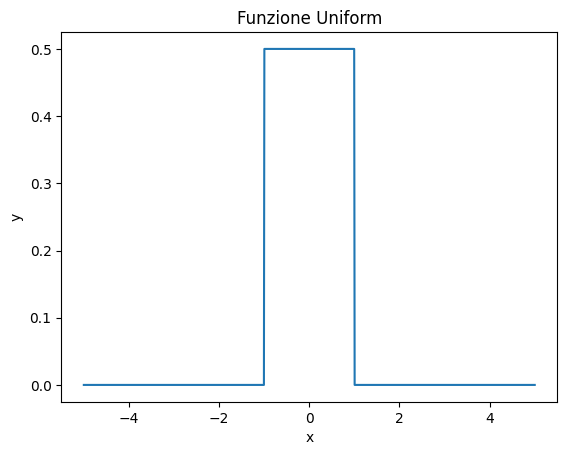

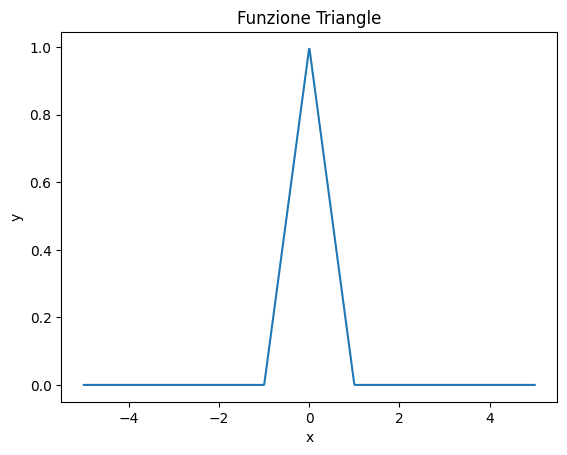

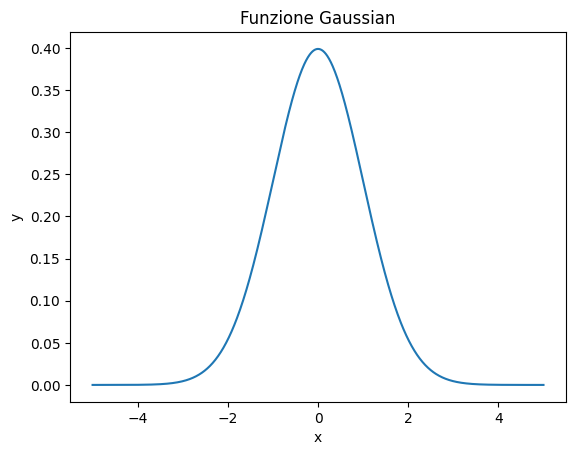

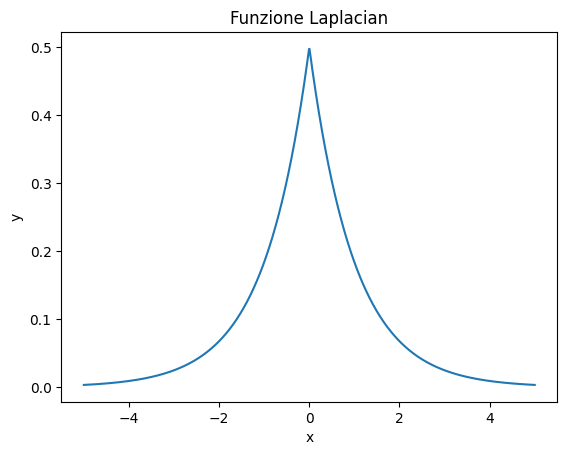

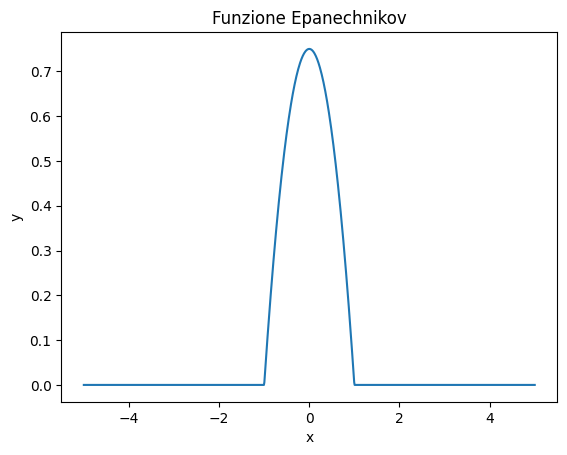

In [6]:
# Definizione di diverse funzioni kernel utilizzate nell'algoritmo di smoothing

# Uniform kernel
# La funzione restituisce 1/2 se l'argomento è compreso tra -b e b, altrimenti restituisce 0
uniform = lambda x,b: (np.abs(x/b) <= 1) and 1/2 or 0 
genera_grafico("Uniform",uniform)

# Triangular kernel
# La funzione restituisce 1 - l'argomento normalizzato per b se l'argomento è compreso tra -b e b, altrimenti restituisce 0
triangle = lambda x,b: (np.abs(x/b) <= 1) and  (1 - np.abs(x/b)) or 0 
genera_grafico("Triangle",triangle)

# Gaussian kernel
# La funzione restituisce il valore della distribuzione gaussiana centrata in 0 e con deviazione standard b valutata in x
gaussian = lambda x,b: (1.0/np.sqrt(2*np.pi))* np.exp(-.5*(x/b)**2) 
genera_grafico("Gaussian",gaussian)

# Laplacian kernel
# La funzione restituisce il valore della distribuzione di Laplace centrata in 0 e con parametro di scala b valutata in x
laplacian = lambda x,b: (1.0/(2*b))* np.exp(-np.abs(x/b)) 
genera_grafico("Laplacian",laplacian)

# Epanechnikov kernel
# La funzione restituisce (3/4)*(1 - l'argomento normalizzato per b elevato al quadrato) se l'argomento è compreso tra -b e b, altrimenti restituisce 0
epanechnikov = lambda x,b: (np.abs(x/b)<=1) and ((3/4)*(1-(x/b)**2)) or 0 
genera_grafico("Epanechnikov",epanechnikov)

## **Creazione del livello Pattern**
Il layer pattern utilizza una funzione kernel per valutare la distanza tra il punto 
di interesse e i punti dell'insieme di addestramento. I valori dei kernel sono utilizzati 
per ponderare i punti dell'insieme di addestramento in base alla loro vicinanza al punto di interesse.

Tuttavia, i dati di addestramento possono contenere rumore o fluttuazioni casuali che possono 
influire negativamente sull'accuratezza del modello. Per ridurre l'effetto del rumore nei dati
di addestramento, viene spesso utilizzata la tecnica di smoothing. In particolare, il parametro 
di smoothing sigma viene utilizzato per regolare l'effetto della distanza sui punti vicini e lontani dal punto di interesse, riducendo l'impatto 
del rumore e migliorando l'accuratezza del modello.

In [7]:
def pattern_layer(inp, kernel, sigma):
  # Inizializzazione di una lista per i valori dei kernel
  k_values = []
  
  # Iterazione su tutti i punti dell'insieme di addestramento
  for i, p in enumerate(X_train.values):
    # Calcolo della distanza euclidea tra il punto di addestramento e il punto di interesse
    edis = np.linalg.norm(p - inp)
    
    # Valutazione del kernel per la distanza euclidea calcolata e il parametro di smoothing sigma
    k = kernel(edis, sigma)
    
    # Aggiunta del valore del kernel alla lista
    k_values.append(k)
    
  # Restituzione della lista dei valori dei kernel
  return k_values

## **Creazione del livello Summation**
La funzione "summation_layer" prende in input una lista di valori del kernel "k_values", 
una serie di etichette di classe "Y_train" e un elenco delle diverse classi presenti nella 
serie di etichette di classe "class_counts". La funzione calcola la somma pesata dei valori 
di "k_values" per ogni classe nella serie di etichette di classe "Y_train" e restituisce una
lista di valori medi ponderati per classe. In particolare, la funzione seleziona gli indici 
corrispondenti alla classe attuale e seleziona i valori di "k_values" corrispondenti alla classe attuale. 
La somma viene quindi divisa per il numero di campioni nella classe corrente, 
ottenuto utilizzando una funzione di Pandas, e il risultato viene normalizzato per ogni classe. 
Infine, la funzione restituisce la lista di valori medi ponderati per classe come output.


In [8]:
def summation_layer(k_values,Y_train,class_counts):
  # Determina il numero di classi diverse in Y_train
  num_classes = len(class_counts)
  # Inizializza un array di zeri con lunghezza uguale al numero di classi
  summed =[0] * num_classes

  # Calcola la somma pesata dei valori di k_values per ogni classe in Y_train
  for i,c in enumerate(class_counts):
    # Seleziona gli indici corrispondenti alla classe attuale
    val = (Y_train['target']==class_counts.index[i]).values;

    # Seleziona i valori di k_values corrispondenti alla classe attuale
    k_values = np.array(k_values);
    summed[i] = np.sum(k_values[val]);
    
  # Calcola la media ponderata dei valori per ogni classe
  avg_sum = list(summed/Y_train.value_counts());

  # Restituisce la lista di valori medi ponderati per classe
  return avg_sum

## **Creazione del livello di Output**
La funzione "output_layer" prende in input una lista di valori medi ponderati per classe "avg_sum"
e un elenco delle diverse classi presenti nella serie di etichette di classe "class_counts". 
La funzione restituisce l'etichetta di classe corrispondente all'indice dell'elemento massimo nella lista
delle medie delle somme dei valori di "k_values" per ogni classe. In particolare, la funzione determina il
valore massimo nella lista delle medie delle somme dei valori di "k_values" per ogni classe, quindi determina
l'indice dell'elemento massimo nella lista e infine determina l'etichetta di classe corrispondente all'indice
dell'elemento massimo nella lista delle medie delle somme dei valori di "k_values" per ogni classe.
Infine, la funzione restituisce l'etichetta di classe come una stringa come output.



In [9]:
def output_layer(avg_sum, class_counts):
  # Determina il valore massimo nella lista delle medie delle somme dei valori di k_values per ogni classe
  max_value = max(avg_sum)
  
  # Determina l'indice dell'elemento massimo nella lista delle medie delle somme dei valori di k_values per ogni classe
  max_index = avg_sum.index(max_value)
  
  # Determina l'etichetta di classe corrispondente all'indice dell'elemento massimo nella lista delle medie delle somme dei valori di k_values per ogni classe
  label = class_counts.index[max_index][0]
  
  # Restituisce l'etichetta di classe come una stringa
  return label

## **Unione dei tre livelli della Probabilistic Neural Network**
La funzione pnn implementa un classificatore denominato "Probabilistic Neural Network" (PNN) per la classificazione
di un set di dati X_test sulla base di un set di dati di training X_train con le relative etichette di classe Y_train.
Viene calcolata una stima della densità di probabilità per ogni classe presente in Y_train utilizzando 
una funzione kernel (specificata come parametro) e una larghezza di banda sigma (anche questo come parametro). 
Successivamente, per ogni osservazione in X_test, la funzione utilizza le stime di densità di probabilità 
per calcolare la probabilità che l'osservazione appartenga a ciascuna classe presente in Y_train. 
Infine, l'etichetta di classe con la probabilità più alta viene assegnata all'osservazione e viene aggiunta 
alla lista di etichette di classe generate.
La funzione restituisce la lista di etichette di classe generate e stampa un messaggio di conferma.

In [10]:
def pnn(X_train,Y_train,X_test,kernel,sigma):
  # Determina il conteggio di ogni classe nella serie di etichette di classe Y_train
  class_counts = Y_train.value_counts()
  
  # Inizializza una lista vuota per le etichette di classe generate
  labels=[]
  
  # Iterazione su ogni osservazione del set di test
  for s in X_test.values:
    # Calcola i valori del kernel per l'osservazione attuale
    k_values = pattern_layer(s,kernel,sigma);
    
    # Calcola la somma pesata dei valori del kernel per ogni classe presente nella serie di etichette di classe Y_train
    avg_sum = summation_layer(k_values,Y_train,class_counts);
    
    # Determina l'etichetta di classe corrispondente all'osservazione attuale
    label = output_layer(avg_sum,class_counts);
    
    # Aggiunge l'etichetta di classe alla lista delle etichette di classe generate
    labels.append(label);

  # Restituisce la lista delle etichette di classe generate
  return labels;

# Applicazione Particle Swarm Optimization per ricerca parametri ottimi
In questa sezione si utilizza l'algoritmo PSO(Particle Swarm Optimization) per l'ottimizzazione dei parametri di una PNN, in modo da trovare i valori ottimali di sigma e del kernel che massimizzino la sua capacità di generalizzazione sui dati di test. L'algoritmo PSO utilizza una funzione obiettivo per valutare la qualità delle soluzioni candidate e cerca di trovare i valori ottimali dei parametri muovendo le particelle verso le soluzioni migliori. Alla fine dell'ottimizzazione, il notebook restituisce i valori di sigma e del kernel ottimali, insieme alla metrica di performance, che possono essere utilizzati per addestrare e testare la PNN con i dati di addestramento e di test.





*   options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}: questi sono i parametri dell'algoritmo PSO. In particolare, 'c1' e 'c2' rappresentano i coefficienti di accelerazione cognitiva e sociale, rispettivamente, mentre 'w' rappresenta il peso dell'inerzia. Questi parametri controllano la velocità con cui le particelle si muovono verso la migliore soluzione individuale e globale, nonché l'effetto dell'inerzia sulla loro velocità.
*   bounds = ([0.1], [1.8]): questi sono i limiti inferiori e superiori per il valore di sigma, il parametro che stiamo cercando di ottimizzare. In particolare, abbiamo impostato il limite inferiore a 0.1 e il limite superiore a 1.8, poiché sappiamo che il valore ottimale di sigma si trova in questo intervallo.

*   n_particles = 30: questo parametro indica il numero di particelle utilizzate nell'algoritmo PSO. Un numero più elevato di particelle può aumentare la precisione dell'ottimizzazione, ma richiede anchepiù tempo di esecuzione.

*   n_iterations = 100: questo parametro indica il numero di iterazioni dell'algoritmo PSO. Più iterazioni possono migliorare la precisione dell'ottimizzazione, ma richiedono anche più tempo di esecuzione. Abbiamo scelto 100 iterazioni poiché abbiamo verificato che questo valore è sufficiente per raggiungere la convergenza dell'algoritmo.

In [19]:
!pip install pyswarms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.7 MB/s eta 0:00:00


## CH-SIMS CMU-MOSEI

In [20]:
import pyswarms as ps
import pandas as pd

# Definisci la funzione obiettivo per l'ottimizzazione
def pnn_accuracy_score(x):
    kernel = gaussian  # Utilizza il kernel gaussiano
    preds = pnn(X_train, Y_train, X_test, kernel, x[0])  # Utilizza x[0] come valore di sigma
    return -accuracy_score(Y_test, preds)  # Negare il punteggio di accuratezza per la massimizzazione

# Carica il dataset "chsims_cmumosei"
X_train, Y_train, X_test, Y_test = carica_dataset_train_test_chsims_cmumosei()

# Imposta i parametri per l'algoritmo PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
bounds = ([0.1], [1.8])  # Imposta i limiti inferiori e superiori per sigma
n_particles = 45
n_iterations = 100

# Esegui l'ottimizzazione
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=1, options=options, bounds=bounds)
best_cost,best_pos = optimizer.optimize(pnn_accuracy_score, n_iterations)

# Ottieni la massima accuratezza e sigma ottimizzato
accuracy_max = -best_cost
sigma_opt = best_pos[0]  # Estrai sigma ottimizzato dall'array della migliore posizione

# Stampa la massima accuratezza e sigma ottimizzato
print("Massima Accuratezza:", accuracy_max)
print("Sigma Ottimizzato:", sigma_opt)

# Crea un DataFrame con i valori ottimi di sigma
df_sigma = pd.DataFrame({'Sigma Ottimo': [sigma_opt]})

# verifica se la cartella di destinazione esiste, altrimenti la crea
if not os.path.exists(path_principale + '/Codici PNN/Sigma ottimi/CH-SIMS CMU-MOSEI/'):
    os.makedirs(path_principale + '/Codici PNN/Sigma ottimi/CH-SIMS CMU-MOSEI/')


# Salva il DataFrame in un file CSV
df_sigma.to_csv(path_principale + '/Codici PNN/Sigma ottimi/CH-SIMS CMU-MOSEI/' + 'sigma_ottimo_gauss_chsims_cmumosei.csv', index=False)

2023-06-12 19:59:26,931 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-.69
2023-06-12 20:01:24,776 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6904761904761905, best pos: [0.1096322]


Massima Accuratezza: 0.6904761904761905
Sigma Ottimizzato: 0.10963220276525765


# Applicazione della PNN
sigma rappresenta il parametro di smoothing utilizzato nell'algoritmo di Parzen-Window.
L'algoritmo di Parzen-Window è un metodo non parametrico per la stima della densità di probabilità 
di una variabile casuale. In questo algoritmo, si utilizza una finestra di dimensione sigma per calcolare 
la densità di probabilità stimata.
Il parametro sigma controlla la larghezza della finestra, ovvero la distanza entro cui viene calcolata 
la densità di probabilità stimata. Un valore di sigma maggiore indica che la finestra è più ampia e quindi 
si considerano più dati per la stima della densità di probabilità, 
mentre un valore di sigma minore indica che la finestra è più stretta e quindi si considerano meno dati per 
la stima della densità di probabilità.

## CH-SIMS CMU-MOSEI

In [16]:
def create_confusion_matrix(Y_test, pred, labels, sigma, kernel, save_path=None, filename=None):
  cm = confusion_matrix(Y_test.values, pred)

  # Plot della matrice di confusione
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Reds', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Matrice di confusione (sigma='+str(sigma)+' , kernel='+kernel+')')

# Salvataggio dell'immagine della matrice di confusione
  if save_path is not None:
      if filename is not None:
       plt.savefig(save_path + filename+'.png', bbox_inches='tight')
      
      else:
        plt.savefig(save_path + "ConfusionMatrix.png", bbox_inches='tight')
      plt.show()
  else:
      plt.show()

  plt.close()


In [17]:
def valutazione_performance(Y_test, pred):
  accuracy = accuracy_score(Y_test, pred)
  accuracy_100 = "{:.2%}".format(accuracy)
  f1 = "{:.2%}".format(f1_score(Y_test, pred, average='weighted'))
  precision = "{:.2%}".format(precision_score(Y_test, pred, average='micro'))
  recall = "{:.2%}".format(recall_score(Y_test, pred, average='micro'))

  return accuracy, accuracy_100, f1, precision, recall

### Applicazione su Test set 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


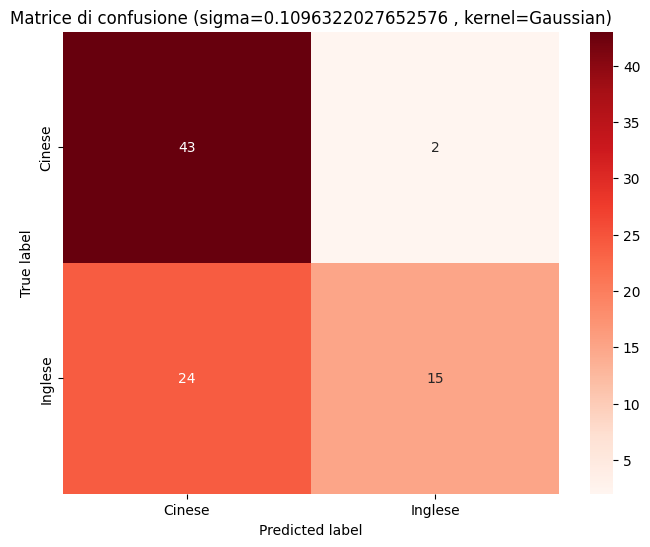

,Kernel,Smoothing Param,Accuracy,Accuracy (%),F1-Score,Precision,Recall
0,Gaussian,0.109632,0.690476,69.05%,66.01%,69.05%,69.05%


     Kernel  Smoothing Param Accuracy (%) F1-Score Precision  Recall
0  Gaussian         0.109632       69.05%   66.01%    69.05%  69.05%
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [21]:
# Definizione della cartella di destinazione per le immagini delle matrici di confusione
output_folder = path_principale + '/Codici PNN/Matrici Confusione/CH-SIMS CMU-MOSEI/'
os.makedirs(output_folder, exist_ok=True)

# Carica il DataFrame del sigma ottimo, utilizzando il kernel gaussiano
df_sigmaOttimo = pd.read_csv(path_principale + '/Codici PNN/Sigma ottimi/CH-SIMS CMU-MOSEI/' + 'sigma_ottimo_gauss_chsims_cmumosei.csv')
sigmaOttimo = df_sigmaOttimo['Sigma Ottimo'][0]


# Definizione della lista di possibili funzioni kernel
k_func = gaussian


X_train, Y_train, X_test, Y_test = carica_dataset_train_test_chsims_cmumosei()

# Inizializzazione di un DataFrame vuoto per salvare le statistiche di performance del classificatore
results = pd.DataFrame(columns=['Kernel', 'Smoothing Param', 'Accuracy', 'Accuracy (%)', 'F1-Score', 'Precision', 'Recall'])

print("---" * 100)

# Generazione delle etichette di classe per il set di test utilizzando la funzione kernel corrente e il valore di sigma corrente 
pred = pnn(X_train, Y_train, X_test, k_func, sigmaOttimo)

# Creazione della matrice di confusione
labels = ['Cinese', 'Inglese']

# Calcolo delle metriche di performance in %
accuracy, accuracy_100, f1, precision, recall = valutazione_performance(Y_test.values, pred)

#stampa matrice di confusione
nome_file = 'CM_test_chsims_cmumosei_A'+format(accuracy, '.2f')
create_confusion_matrix(Y_test, pred, labels, sigmaOttimo, "Gaussian", output_folder , nome_file )


# Aggiunta delle statistiche di performance per la combinazione corrente di kernel e sigma al DataFrame results
results.loc[len(results)] = ["Gaussian", sigmaOttimo, accuracy, accuracy_100, f1, precision, recall]

display(results)
csv_path = "/content/drive/Shareddrives/Progetti FVAB 22 23 - VSR & BABELE/Gruppi/Gruppo 22/Progetto BABELE/CSV_PNN_RESULT/results_CHSIM-MOSEI.csv" 
results.to_csv(csv_path, index=False) 

# Stampa del DataFrame results. Per un questione di stile elimino la colonna accuracy, è presente l'accuracy in percentuale
print(results.drop(columns=['Accuracy']))
print("---" * 100)